In [5]:
import pandas as pd
import numpy as np
from pycaret.regression import *

# Load your dataset
df = pd.read_csv("data_preprocess\export-pm25_eng-1h.csv", parse_dates=["timestamp"], index_col="timestamp")
df = df.sort_values(by="timestamp")
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month
df['day'] = df.index.day
df.head()


,Unnamed: 0,timezone,humidity,pm_10,pm_2_5,pm_2_5_sp,temperature,dayofweek,month,day
timestamp,,,,,,,,,,
2023-03-31 22:00:00,0,Asia/Bangkok,62.659563,4.727273,4.727273,4.727273,27.147784,4,3,31
2023-04-02 18:00:00,1,Asia/Bangkok,69.995698,7.857143,7.142857,7.142857,32.246966,6,4,2
2023-04-02 19:00:00,2,Asia/Bangkok,65.608215,8.400000,7.800000,7.800000,32.518829,6,4,2
2023-04-02 20:00:00,3,Asia/Bangkok,65.489705,8.750000,8.266667,8.266667,31.864227,6,4,2
2023-04-02 21:00:00,4,Asia/Bangkok,65.811462,10.316667,9.083333,9.083333,31.412888,6,4,2


In [6]:
# Create lag features for the past 7 days
for lag in range(1, 8):  # Lags from 1 to 7 days
    df[f'pm_2_5_lag_{lag}'] = df['pm_2_5'].shift(lag)

# Drop NaN values caused by shifting
df.dropna(inplace=True)
df = df.drop(columns=["Unnamed: 0", "timezone", "pm_2_5_sp", 'pm_10'], axis=1)
df

,humidity,pm_2_5,temperature,dayofweek,month,day,pm_2_5_lag_1,pm_2_5_lag_2,pm_2_5_lag_3,pm_2_5_lag_4,pm_2_5_lag_5,pm_2_5_lag_6,pm_2_5_lag_7
timestamp,,,,,,,,,,,,,
2023-04-03 00:00:00,66.876119,7.200000,30.042084,0,4,3,7.466667,9.366667,9.083333,8.266667,7.800000,7.142857,4.727273
2023-04-03 01:00:00,67.430725,7.783333,29.392181,0,4,3,7.200000,7.466667,9.366667,9.083333,8.266667,7.800000,7.142857
2023-04-03 02:00:00,68.017985,16.500000,29.118591,0,4,3,7.783333,7.200000,7.466667,9.366667,9.083333,8.266667,7.800000
2023-04-03 03:00:00,68.853455,24.783333,28.612701,0,4,3,16.500000,7.783333,7.200000,7.466667,9.366667,9.083333,8.266667
2023-04-03 04:00:00,69.691119,28.543860,28.313422,0,4,3,24.783333,16.500000,7.783333,7.200000,7.466667,9.366667,9.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-11 08:00:00,90.929747,37.568627,23.684319,1,2,11,31.325581,28.533333,28.383333,28.883333,27.033333,26.355932,25.416667
2025-02-11 09:00:00,83.511569,38.800000,25.896389,1,2,11,37.568627,31.325581,28.533333,28.383333,28.883333,27.033333,26.355932
2025-02-11 10:00:00,72.046736,23.333333,28.852626,1,2,11,38.800000,37.568627,31.325581,28.533333,28.383333,28.883333,27.033333


In [7]:
from scipy import stats
df = df[(np.abs(stats.zscore(df['humidity'])) < 3)]  # ลบค่าผิดปกติออก
df = df[(np.abs(stats.zscore(df['temperature'])) < 3)]  # ลบค่าผิดปกติออก
df = df[(np.abs(stats.zscore(df['pm_2_5'])) < 3)]  # ลบค่าผิดปกติออก
df

,humidity,pm_2_5,temperature,dayofweek,month,day,pm_2_5_lag_1,pm_2_5_lag_2,pm_2_5_lag_3,pm_2_5_lag_4,pm_2_5_lag_5,pm_2_5_lag_6,pm_2_5_lag_7
timestamp,,,,,,,,,,,,,
2023-04-03 00:00:00,66.876119,7.200000,30.042084,0,4,3,7.466667,9.366667,9.083333,8.266667,7.800000,7.142857,4.727273
2023-04-03 01:00:00,67.430725,7.783333,29.392181,0,4,3,7.200000,7.466667,9.366667,9.083333,8.266667,7.800000,7.142857
2023-04-03 02:00:00,68.017985,16.500000,29.118591,0,4,3,7.783333,7.200000,7.466667,9.366667,9.083333,8.266667,7.800000
2023-04-03 03:00:00,68.853455,24.783333,28.612701,0,4,3,16.500000,7.783333,7.200000,7.466667,9.366667,9.083333,8.266667
2023-04-03 04:00:00,69.691119,28.543860,28.313422,0,4,3,24.783333,16.500000,7.783333,7.200000,7.466667,9.366667,9.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-11 08:00:00,90.929747,37.568627,23.684319,1,2,11,31.325581,28.533333,28.383333,28.883333,27.033333,26.355932,25.416667
2025-02-11 09:00:00,83.511569,38.800000,25.896389,1,2,11,37.568627,31.325581,28.533333,28.383333,28.883333,27.033333,26.355932
2025-02-11 10:00:00,72.046736,23.333333,28.852626,1,2,11,38.800000,37.568627,31.325581,28.533333,28.383333,28.883333,27.033333


In [8]:
compare_data = df[-7:]  # Last 7 known values
compare_data
df = df[:-7]
compare_data

,humidity,pm_2_5,temperature,dayofweek,month,day,pm_2_5_lag_1,pm_2_5_lag_2,pm_2_5_lag_3,pm_2_5_lag_4,pm_2_5_lag_5,pm_2_5_lag_6,pm_2_5_lag_7
timestamp,,,,,,,,,,,,,
2025-02-10 21:00:00,77.279939,28.533333,26.323620,0,2,10,28.383333,28.883333,27.033333,26.355932,25.416667,25.450000,25.183333
2025-02-10 22:00:00,78.573505,31.325581,26.209783,0,2,10,28.533333,28.383333,28.883333,27.033333,26.355932,25.416667,25.450000
2025-02-11 08:00:00,90.929747,37.568627,23.684319,1,2,11,31.325581,28.533333,28.383333,28.883333,27.033333,26.355932,25.416667
2025-02-11 09:00:00,83.511569,38.800000,25.896389,1,2,11,37.568627,31.325581,28.533333,28.383333,28.883333,27.033333,26.355932
2025-02-11 10:00:00,72.046736,23.333333,28.852626,1,2,11,38.800000,37.568627,31.325581,28.533333,28.383333,28.883333,27.033333
2025-02-11 11:00:00,64.332405,21.850000,30.593716,1,2,11,23.333333,38.800000,37.568627,31.325581,28.533333,28.383333,28.883333
2025-02-11 11:15:36,61.046112,21.000000,31.861472,1,2,11,21.850000,23.333333,38.800000,37.568627,31.325581,28.533333,28.383333


In [9]:
exp = setup(data=df, target='pm_2_5', fold=10, session_id=123, iterative_imputation_iters=100, remove_outliers = True, use_gpu=True)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

,Description,Value
0,Session id,123
1,Target,pm_2_5
2,Target type,Regression
3,Original data shape,"(14303, 13)"
4,Transformed data shape,"(13802, 13)"
5,Transformed train set shape,"(9511, 13)"
6,Transformed test set shape,"(4291, 13)"
7,Numeric features,12
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

In [10]:
best_model = exp.compare_models()  # Find the best regression model

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,3.3571,25.0471,5.0004,0.8391,0.2804,0.2385,1.5030
gbr,Gradient Boosting Regressor,3.3747,25.0654,5.0014,0.8390,0.2816,0.2432,2.4620
et,Extra Trees Regressor,3.4418,25.7841,5.0735,0.8344,0.2887,0.2510,0.6200
rf,Random Forest Regressor,3.4664,26.3409,5.1290,0.8308,0.2924,0.2530,1.3930
lr,Linear Regression,3.4865,28.8045,5.3264,0.8157,0.2917,0.2584,0.2190
ridge,Ridge Regression,3.4865,28.8044,5.3264,0.8157,0.2917,0.2584,0.2070
br,Bayesian Ridge,3.4875,28.8034,5.3265,0.8157,0.2919,0.2586,0.3290
en,Elastic Net,3.5124,28.9357,5.3452,0.8148,0.2933,0.2625,0.1940
lar,Least Angle Regression,3.4925,28.9414,5.3387,0.8148,0.2921,0.2588,0.2010
lasso,Lasso Regression,3.5209,29.1012,5.3619,0.8137,0.2943,0.2640,0.1940


In [11]:
best_model = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.4363,27.2363,5.2188,0.8288,0.2826,0.2348
1,3.3431,24.8127,4.9812,0.8474,0.2811,0.2409
2,3.3900,24.7727,4.9772,0.8359,0.2674,0.2298
3,3.3276,23.5955,4.8575,0.8557,0.2910,0.2498
4,3.4870,28.3576,5.3252,0.8127,0.2943,0.2494
5,3.2602,23.4436,4.8419,0.8488,0.2686,0.2312
6,3.1574,21.2309,4.6077,0.8580,0.2849,0.2442
7,3.2563,23.7015,4.8684,0.8508,0.2714,0.2273
8,3.5214,27.0263,5.1987,0.8183,0.2883,0.2483


In [12]:
exp.predict_model(best_model,data=df)  # Train the best model on the entire dataset

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.8905,17.9784,4.2401,0.8841,0.2473,0.2084


,humidity,temperature,dayofweek,month,day,pm_2_5_lag_1,pm_2_5_lag_2,pm_2_5_lag_3,pm_2_5_lag_4,pm_2_5_lag_5,pm_2_5_lag_6,pm_2_5_lag_7,pm_2_5,prediction_label
timestamp,,,,,,,,,,,,,,
2023-04-03 00:00:00,66.876122,30.042084,0,4,3,7.466667,9.366667,9.083333,8.266666,7.800000,7.142857,4.727273,7.200000,9.001109
2023-04-03 01:00:00,67.430725,29.392181,0,4,3,7.200000,7.466667,9.366667,9.083333,8.266666,7.800000,7.142857,7.783333,8.559932
2023-04-03 02:00:00,68.017982,29.118591,0,4,3,7.783333,7.200000,7.466667,9.366667,9.083333,8.266666,7.800000,16.500000,9.631116
2023-04-03 03:00:00,68.853455,28.612701,0,4,3,16.500000,7.783333,7.200000,7.466667,9.366667,9.083333,8.266666,24.783333,20.105598
2023-04-03 04:00:00,69.691116,28.313421,0,4,3,24.783333,16.500000,7.783333,7.200000,7.466667,9.366667,9.083333,28.543859,27.058923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-10 16:00:00,63.063889,30.294567,0,2,10,25.450001,25.183332,25.016666,26.033333,26.650000,26.810345,28.666666,25.416666,25.937824
2025-02-10 17:00:00,66.199043,29.137453,0,2,10,25.416666,25.450001,25.183332,25.016666,26.033333,26.650000,26.810345,26.355932,26.116427
2025-02-10 18:00:00,68.488899,28.289711,0,2,10,26.355932,25.416666,25.450001,25.183332,25.016666,26.033333,26.650000,27.033333,26.728687


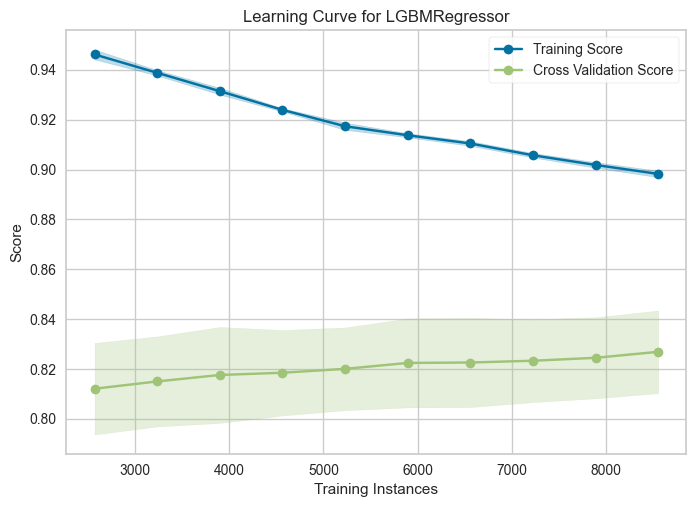

In [10]:
exp.plot_model(best_model, plot='learning')

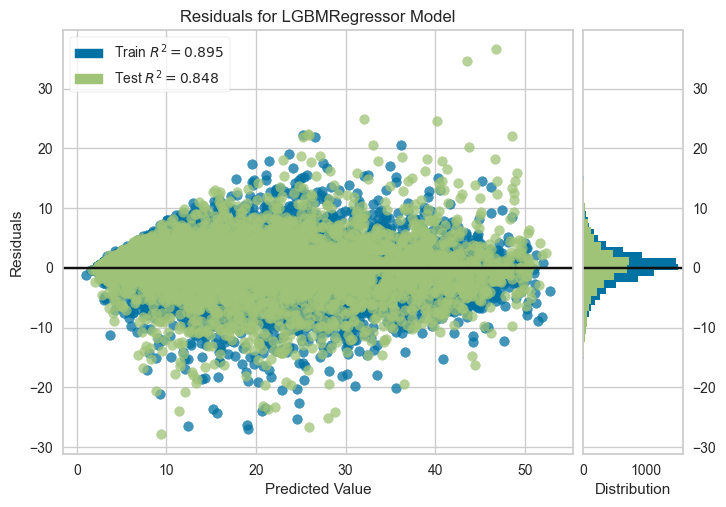

In [11]:
exp.plot_model(best_model)

In [13]:
# Get the last row (most recent data point)
latest_data = df.iloc[-1:].copy()

# Shift lag features forward by 1 day
for lag in range(1, 8):
    latest_data[f'pm_2_5_lag_{lag}'] = df['pm_2_5'].iloc[-lag]

# Make predictions
future_pred = exp.predict_model(best_model, data=latest_data)
future_pred

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.2649,0.0702,0.2649,nan,0.0090,0.0093


,humidity,temperature,dayofweek,month,day,pm_2_5_lag_1,pm_2_5_lag_2,pm_2_5_lag_3,pm_2_5_lag_4,pm_2_5_lag_5,pm_2_5_lag_6,pm_2_5_lag_7,pm_2_5,prediction_label
timestamp,,,,,,,,,,,,,,
2025-02-10 20:00:00,76.134628,26.503902,0,2,10,28.383333,28.883333,27.033333,26.355932,25.416666,25.450001,25.183332,28.383333,28.648275


**Test with other Data**
use data_preprocess\export-pm25_eng-1d.csv to test best_model

In [26]:
df_test = pd.read_csv("data_preprocess\export-r202_test_nbiot-1h.csv", parse_dates=["timestamp"], index_col="timestamp")
df_test = df_test.sort_values(by="timestamp")
df_test['dayofweek'] = df_test.index.dayofweek
df_test['month'] = df_test.index.month
df_test['day'] = df_test.index.day

In [ ]:
# Create lag features for the past 7 days
for lag in range(1, 8):  # Lags from 1 to 7 days
    df_test[f'pm_2_5_lag_{lag}'] = df_test['pm_2_5'].shift(lag)

# Drop NaN values caused by shifting
df_test.dropna(inplace=True)
df_test = df_test.drop(columns=["Unnamed: 0", "timezone", "pm_2_5_sp", 'pm_10'], axis=1)

In [28]:
df_test = df_test[(np.abs(stats.zscore(df_test['humidity'])) < 3)]  # ลบค่าผิดปกติออก
df_test = df_test[(np.abs(stats.zscore(df_test['temperature'])) < 3)]  # ลบค่าผิดปกติออก
df_test = df_test[(np.abs(stats.zscore(df_test['pm_2_5'])) < 3)]  # ลบค่าผิดปกติออก

In [29]:
predict_df_test = exp.predict_model(best_model, data=df_test)
predict_df_test

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,3.3688,24.1748,4.9168,0.8508,0.2988,0.2842


,humidity,pm_10,temperature,dayofweek,month,day,pm_2_5_lag_1,pm_2_5_lag_2,pm_2_5_lag_3,pm_2_5_lag_4,pm_2_5_lag_5,pm_2_5_lag_6,pm_2_5_lag_7,pm_2_5,prediction_label
timestamp,,,,,,,,,,,,,,,
2023-04-09 19:00:00,64.539894,15.983334,32.495163,6,4,9,13.483334,12.326530,11.590909,10.944445,3.916667,3.500000,1.000000,15.333333,15.280617
2023-04-09 20:00:00,64.838257,18.566668,32.314560,6,4,9,15.333333,13.483334,12.326530,11.590909,10.944445,3.916667,3.500000,17.633333,16.849696
2023-04-09 21:00:00,63.953362,16.949152,32.994701,6,4,9,17.633333,15.333333,13.483334,12.326530,11.590909,10.944445,3.916667,15.881356,18.170622
2023-04-09 22:00:00,64.680077,16.866667,33.120392,6,4,9,15.881356,17.633333,15.333333,13.483334,12.326530,11.590909,10.944445,15.966666,15.561519
2023-04-09 23:00:00,68.699341,18.250000,33.047546,6,4,9,15.966666,15.881356,17.633333,15.333333,13.483334,12.326530,11.590909,17.700001,16.219122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-26 12:00:00,62.034443,47.700001,32.720982,2,6,26,48.716667,63.083332,93.949997,86.440681,90.983330,91.533333,61.349998,40.650002,46.345336
2024-06-26 13:00:00,57.990635,40.683334,33.358208,2,6,26,40.650002,48.716667,63.083332,93.949997,86.440681,90.983330,91.533333,35.633335,36.425048
2024-06-26 14:00:00,66.245377,50.116665,32.688988,2,6,26,35.633335,40.650002,48.716667,63.083332,93.949997,86.440681,90.983330,42.216667,34.150344


In [17]:
from pycaret.regression import *
from sklearn.metrics import r2_score


In [18]:
# Predict on a test set (known values)
test_predictions2 = exp.predict_model(best_model, data=compare_data)  # Last 7 known values
test_predictions2
# Compute R² manually


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.8827,28.4557,5.3344,0.3819,0.1738,0.1156


,humidity,temperature,dayofweek,month,day,pm_2_5_lag_1,pm_2_5_lag_2,pm_2_5_lag_3,pm_2_5_lag_4,pm_2_5_lag_5,pm_2_5_lag_6,pm_2_5_lag_7,pm_2_5,prediction_label
timestamp,,,,,,,,,,,,,,
2025-02-10 21:00:00,77.279938,26.323620,0,2,10,28.383333,28.883333,27.033333,26.355932,25.416666,25.450001,25.183332,28.533333,28.750297
2025-02-10 22:00:00,78.573502,26.209784,0,2,10,28.533333,28.383333,28.883333,27.033333,26.355932,25.416666,25.450001,31.325581,29.069913
2025-02-11 08:00:00,90.929749,23.684319,1,2,11,31.325581,28.533333,28.383333,28.883333,27.033333,26.355932,25.416666,37.568626,35.884625
2025-02-11 09:00:00,83.511566,25.896389,1,2,11,37.568626,31.325581,28.533333,28.383333,28.883333,27.033333,26.355932,38.799999,38.266763
2025-02-11 10:00:00,72.046738,28.852625,1,2,11,38.799999,37.568626,31.325581,28.533333,28.383333,28.883333,27.033333,23.333334,37.093894
2025-02-11 11:00:00,64.332405,30.593716,1,2,11,23.333334,38.799999,37.568626,31.325581,28.533333,28.383333,28.883333,21.850000,21.194686
2025-02-11 11:15:36,61.046112,31.861471,1,2,11,21.850000,23.333334,38.799999,37.568626,31.325581,28.533333,28.383333,21.000000,22.073273


In [19]:
r2 = r2_score(compare_data["pm_2_5"], test_predictions2["prediction_label"])
print("R² Score on Test Data:", r2)

R² Score on Test Data: 0.3819196035789021


**Predict Future 7 days**


เอาเป็นรายวันเลย ไม่ work

In [20]:
# สร้างฟังก์ชันสำหรับหาค่าเฉลี่ยจากข้อมูลในอดีตตามวันและเดือน
def get_estimated_value(df, date, column):
    """
    หาค่าเฉลี่ยของคอลัมน์ที่ระบุจากข้อมูลในอดีต โดยใช้เงื่อนไขวันและเดือนเดียวกัน
    
    Parameters:
    df (DataFrame): DataFrame ที่มีข้อมูลในอดีต
    date (Timestamp): วันที่ต้องการประมาณค่า
    column (str): ชื่อคอลัมน์ที่ต้องการหาค่าเฉลี่ย
    
    Returns:
    float: ค่าเฉลี่ยของคอลัมน์ที่ระบุ
    """
    # หาข้อมูลที่มีเดือนและวันเดียวกัน
    historical_data = df[(df.index.month == date.month) & (df.index.day == date.day)]
    
    if len(historical_data) > 0:
        # ถ้ามีข้อมูลในวันและเดือนเดียวกัน
        return historical_data[column].mean()
    elif len(df[df.index.month == date.month]) > 0:
        # ถ้าไม่มีข้อมูลในวันเดียวกัน ให้ใช้ข้อมูลในเดือนเดียวกัน
        return df[df.index.month == date.month][column].mean()
    else:
        # ถ้าไม่มีข้อมูลที่เกี่ยวข้องเลย ให้ใช้ค่าเฉลี่ยทั้งหมด
        return df[column].mean()

# สร้างช่วงเวลาในอนาคต
future_dates = pd.date_range(start=df.index[-1], periods=8, freq='D')[1:]
future_predictions = []
latest_input = latest_data.copy()

# เก็บ DataFrame เดิมไว้สำหรับการอ้างอิงค่าในอดีต
historical_df = df.copy()

for date in future_dates:
    # อัปเดตคุณลักษณะตามเวลา
    latest_input['dayofweek'] = date.dayofweek
    latest_input['month'] = date.month
    latest_input['day'] = date.day
    
    # อัปเดตคุณลักษณะสภาพอากาศโดยใช้ค่าเฉลี่ยจากข้อมูลในอดีต
    latest_input['temperature'] = get_estimated_value(historical_df, date, 'temperature')
    latest_input['humidity'] = get_estimated_value(historical_df, date, 'humidity')
    
    # ทำนายค่า PM2.5
    pred = exp.predict_model(best_model, data=latest_input)['prediction_label'].values[0]
    
    # เก็บค่าทำนาย
    future_predictions.append((date, pred))
    
    # อัปเดต lag features
    for lag in range(7, 1, -1):
        latest_input[f'pm_2_5_lag_{lag}'] = latest_input[f'pm_2_5_lag_{lag-1}']
    latest_input[f'pm_2_5_lag_1'] = pred

# แปลงเป็น DataFrame
future_df = pd.DataFrame(future_predictions, columns=['timestamp', 'pm_2_5'])
future_df.set_index('timestamp', inplace=True)
future_df

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1229,0.0151,0.1229,nan,0.0042,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1055,0.0111,0.1055,nan,0.0036,0.0037


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1756,0.0308,0.1756,nan,0.0060,0.0062


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.2505,0.0627,0.2505,nan,0.0085,0.0088


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.3198,0.1023,0.3198,nan,0.0108,0.0113


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.2075,0.0430,0.2075,nan,0.0070,0.0073


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.8024,0.6439,0.8024,nan,0.0269,0.0283


,pm_2_5
timestamp,
2025-02-11 20:00:00,28.506236
2025-02-12 20:00:00,28.488838
2025-02-13 20:00:00,28.558904
2025-02-14 20:00:00,28.633827
2025-02-15 20:00:00,28.703176
2025-02-16 20:00:00,28.590796
2025-02-17 20:00:00,29.185770


เอาเป็นรายชั่วโมง แล้วมาเฉลี่ยเป็นรายวัน มีทรงกว่า

In [ ]:
# สร้างฟังก์ชันสำหรับหาค่าเฉลี่ยจากข้อมูลในอดีตตามวันและเดือน
def get_estimated_value(df, date, column):
    """
    หาค่าเฉลี่ยของคอลัมน์ที่ระบุจากข้อมูลในอดีต โดยใช้เงื่อนไขวันและเดือนเดียวกัน
    
    Parameters:
    df (DataFrame): DataFrame ที่มีข้อมูลในอดีต
    date (Timestamp): วันที่ต้องการประมาณค่า
    column (str): ชื่อคอลัมน์ที่ต้องการหาค่าเฉลี่ย
    
    Returns:
    float: ค่าเฉลี่ยของคอลัมน์ที่ระบุ
    """
    # หาข้อมูลที่มีเดือนและวันเดียวกัน
    historical_data = df[(df.index.month == date.month) & (df.index.day == date.day)]
    
    if len(historical_data) > 0:
        # ถ้ามีข้อมูลในวันและเดือนเดียวกัน
        return historical_data[column].mean()
    elif len(df[df.index.month == date.month]) > 0:
        # ถ้าไม่มีข้อมูลในวันเดียวกัน ให้ใช้ข้อมูลในเดือนเดียวกัน
        return df[df.index.month == date.month][column].mean()
    else:
        # ถ้าไม่มีข้อมูลที่เกี่ยวข้องเลย ให้ใช้ค่าเฉลี่ยทั้งหมด
        return df[column].mean()

# สร้างช่วงเวลาในอนาคต
future_dates = pd.date_range(start=df.index[-1], periods=169, freq='H')[1:]
future_predictions = []
latest_input = latest_data.copy()

# เก็บ DataFrame เดิมไว้สำหรับการอ้างอิงค่าในอดีต
historical_df = df.copy()

for date in future_dates:
    # อัปเดตคุณลักษณะตามเวลา
    latest_input['dayofweek'] = date.dayofweek
    latest_input['month'] = date.month
    latest_input['day'] = date.day
    
    # อัปเดตคุณลักษณะสภาพอากาศโดยใช้ค่าเฉลี่ยจากข้อมูลในอดีต
    latest_input['temperature'] = get_estimated_value(historical_df, date, 'temperature')
    latest_input['humidity'] = get_estimated_value(historical_df, date, 'humidity')
    
    # ทำนายค่า PM2.5
    pred = exp.predict_model(best_model, data=latest_input)['prediction_label'].values[0]
    
    # เก็บค่าทำนาย
    future_predictions.append((date, pred))
    
    # อัปเดต lag features
    for lag in range(7, 1, -1):
        latest_input[f'pm_2_5_lag_{lag}'] = latest_input[f'pm_2_5_lag_{lag-1}']
    latest_input[f'pm_2_5_lag_1'] = pred

# แปลงเป็น DataFrame
future_df = pd.DataFrame(future_predictions, columns=['timestamp', 'pm_2_5'])
future_df.set_index('timestamp', inplace=True)
daily_future_df = future_df.resample('D').mean()  # เฉลี่ยเป็นรายวัน
daily_future_df

'''# แสดงเฉพาะวันที่ 7 (วันสุดท้าย) ของการทำนาย
seventh_day_prediction = daily_future_df.iloc[6:7]  # ดัชนี 6 คือวันที่ 7 (เริ่มจาก 0)

# แสดงผลลัพธ์
print(f"ค่า PM2.5 ที่ทำนายสำหรับวันที่ 7: {seventh_day_prediction}")'''

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0318,0.0010,0.0318,nan,0.0011,0.0011


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0492,0.0024,0.0492,nan,0.0017,0.0017


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.5021,0.2521,0.5021,nan,0.0169,0.0177


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.9729,0.9465,0.9729,nan,0.0326,0.0343


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.7853,0.6167,0.7853,nan,0.0264,0.0277


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.2105,0.0443,0.2105,nan,0.0071,0.0074


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0381,0.0015,0.0381,nan,0.0013,0.0013


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.6569,0.4315,0.6569,nan,0.0221,0.0231


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.9729,0.9465,0.9729,nan,0.0326,0.0343


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.6049,0.3659,0.6049,nan,0.0204,0.0213


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.2502,0.0626,0.2502,nan,0.0085,0.0088


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1578,0.0249,0.1578,nan,0.0054,0.0056


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.6569,0.4315,0.6569,nan,0.0221,0.0231


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.7332,0.5376,0.7332,nan,0.0246,0.0258


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.2502,0.0626,0.2502,nan,0.0085,0.0088


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0016,0.0000,0.0016,nan,0.0001,0.0001


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.6966,0.4852,0.6966,nan,0.0234,0.0245


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.7332,0.5376,0.7332,nan,0.0246,0.0258


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.2105,0.0443,0.2105,nan,0.0071,0.0074


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0016,0.0000,0.0016,nan,0.0001,0.0001


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.6966,0.4852,0.6966,nan,0.0234,0.0245


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.7332,0.5376,0.7332,nan,0.0246,0.0258


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.2105,0.0443,0.2105,nan,0.0071,0.0074


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0016,0.0000,0.0016,nan,0.0001,0.0001


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.6966,0.4852,0.6966,nan,0.0234,0.0245


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.7332,0.5376,0.7332,nan,0.0246,0.0258


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.2105,0.0443,0.2105,nan,0.0071,0.0074


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0016,0.0000,0.0016,nan,0.0001,0.0001


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.6966,0.4852,0.6966,nan,0.0234,0.0245


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.7332,0.5376,0.7332,nan,0.0246,0.0258


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.2105,0.0443,0.2105,nan,0.0071,0.0074


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0016,0.0000,0.0016,nan,0.0001,0.0001


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.6966,0.4852,0.6966,nan,0.0234,0.0245


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.7332,0.5376,0.7332,nan,0.0246,0.0258


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.2105,0.0443,0.2105,nan,0.0071,0.0074


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0016,0.0000,0.0016,nan,0.0001,0.0001


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.6966,0.4852,0.6966,nan,0.0234,0.0245


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.7332,0.5376,0.7332,nan,0.0246,0.0258


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.2105,0.0443,0.2105,nan,0.0071,0.0074


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0016,0.0000,0.0016,nan,0.0001,0.0001


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.6966,0.4852,0.6966,nan,0.0234,0.0245


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.7332,0.5376,0.7332,nan,0.0246,0.0258


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.2105,0.0443,0.2105,nan,0.0071,0.0074


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0016,0.0000,0.0016,nan,0.0001,0.0001


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.6966,0.4852,0.6966,nan,0.0234,0.0245


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.7332,0.5376,0.7332,nan,0.0246,0.0258


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.2105,0.0443,0.2105,nan,0.0071,0.0074


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0016,0.0000,0.0016,nan,0.0001,0.0001


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.6966,0.4852,0.6966,nan,0.0234,0.0245


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.7332,0.5376,0.7332,nan,0.0246,0.0258


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.2105,0.0443,0.2105,nan,0.0071,0.0074


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.2462,0.0606,0.2462,nan,0.0084,0.0087


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.7361,0.5419,0.7361,nan,0.0254,0.0259


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.8862,3.5577,1.8862,nan,0.0663,0.0665


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.2633,5.1223,2.2633,nan,0.0802,0.0797


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1002,4.4107,2.1002,nan,0.0742,0.0740


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.0931,4.3809,2.0931,nan,0.0739,0.0737


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1328,4.5487,2.1328,nan,0.0754,0.0751


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1328,4.5487,2.1328,nan,0.0754,0.0751


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1328,4.5487,2.1328,nan,0.0754,0.0751


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1328,4.5487,2.1328,nan,0.0754,0.0751


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1328,4.5487,2.1328,nan,0.0754,0.0751


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1328,4.5487,2.1328,nan,0.0754,0.0751


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1328,4.5487,2.1328,nan,0.0754,0.0751


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1328,4.5487,2.1328,nan,0.0754,0.0751


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1328,4.5487,2.1328,nan,0.0754,0.0751


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1328,4.5487,2.1328,nan,0.0754,0.0751


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1328,4.5487,2.1328,nan,0.0754,0.0751


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1328,4.5487,2.1328,nan,0.0754,0.0751


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1328,4.5487,2.1328,nan,0.0754,0.0751


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1328,4.5487,2.1328,nan,0.0754,0.0751


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1328,4.5487,2.1328,nan,0.0754,0.0751


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1328,4.5487,2.1328,nan,0.0754,0.0751


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1328,4.5487,2.1328,nan,0.0754,0.0751


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1328,4.5487,2.1328,nan,0.0754,0.0751


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.8674,3.4873,1.8674,nan,0.0657,0.0658


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.8674,3.4873,1.8674,nan,0.0657,0.0658


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.8674,3.4873,1.8674,nan,0.0657,0.0658


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.8674,3.4873,1.8674,nan,0.0657,0.0658


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.8674,3.4873,1.8674,nan,0.0657,0.0658


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.8674,3.4873,1.8674,nan,0.0657,0.0658


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.8674,3.4873,1.8674,nan,0.0657,0.0658


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.8674,3.4873,1.8674,nan,0.0657,0.0658


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.8674,3.4873,1.8674,nan,0.0657,0.0658


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.8674,3.4873,1.8674,nan,0.0657,0.0658


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.8674,3.4873,1.8674,nan,0.0657,0.0658


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.8674,3.4873,1.8674,nan,0.0657,0.0658


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.8674,3.4873,1.8674,nan,0.0657,0.0658


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.8674,3.4873,1.8674,nan,0.0657,0.0658


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.8674,3.4873,1.8674,nan,0.0657,0.0658


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.8674,3.4873,1.8674,nan,0.0657,0.0658


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.8674,3.4873,1.8674,nan,0.0657,0.0658


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.8674,3.4873,1.8674,nan,0.0657,0.0658


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.8674,3.4873,1.8674,nan,0.0657,0.0658


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.8674,3.4873,1.8674,nan,0.0657,0.0658


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.8674,3.4873,1.8674,nan,0.0657,0.0658


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.8674,3.4873,1.8674,nan,0.0657,0.0658


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.8674,3.4873,1.8674,nan,0.0657,0.0658


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.8674,3.4873,1.8674,nan,0.0657,0.0658


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1873,4.7844,2.1873,nan,0.0774,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1873,4.7844,2.1873,nan,0.0774,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1873,4.7844,2.1873,nan,0.0774,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1873,4.7844,2.1873,nan,0.0774,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1873,4.7844,2.1873,nan,0.0774,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1873,4.7844,2.1873,nan,0.0774,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1873,4.7844,2.1873,nan,0.0774,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1873,4.7844,2.1873,nan,0.0774,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1873,4.7844,2.1873,nan,0.0774,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1873,4.7844,2.1873,nan,0.0774,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1873,4.7844,2.1873,nan,0.0774,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1873,4.7844,2.1873,nan,0.0774,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1873,4.7844,2.1873,nan,0.0774,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1873,4.7844,2.1873,nan,0.0774,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1873,4.7844,2.1873,nan,0.0774,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1873,4.7844,2.1873,nan,0.0774,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1873,4.7844,2.1873,nan,0.0774,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1873,4.7844,2.1873,nan,0.0774,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1873,4.7844,2.1873,nan,0.0774,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1873,4.7844,2.1873,nan,0.0774,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1873,4.7844,2.1873,nan,0.0774,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1873,4.7844,2.1873,nan,0.0774,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1873,4.7844,2.1873,nan,0.0774,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1873,4.7844,2.1873,nan,0.0774,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1873,4.7844,2.1873,nan,0.0774,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1873,4.7844,2.1873,nan,0.0774,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1873,4.7844,2.1873,nan,0.0774,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1873,4.7844,2.1873,nan,0.0774,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1873,4.7844,2.1873,nan,0.0774,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1873,4.7844,2.1873,nan,0.0774,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1873,4.7844,2.1873,nan,0.0774,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1873,4.7844,2.1873,nan,0.0774,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1873,4.7844,2.1873,nan,0.0774,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1873,4.7844,2.1873,nan,0.0774,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1873,4.7844,2.1873,nan,0.0774,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1873,4.7844,2.1873,nan,0.0774,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1873,4.7844,2.1873,nan,0.0774,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1873,4.7844,2.1873,nan,0.0774,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1873,4.7844,2.1873,nan,0.0774,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1873,4.7844,2.1873,nan,0.0774,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1873,4.7844,2.1873,nan,0.0774,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1873,4.7844,2.1873,nan,0.0774,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1873,4.7844,2.1873,nan,0.0774,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1873,4.7844,2.1873,nan,0.0774,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1873,4.7844,2.1873,nan,0.0774,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1873,4.7844,2.1873,nan,0.0774,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1873,4.7844,2.1873,nan,0.0774,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1873,4.7844,2.1873,nan,0.0774,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.0304,4.1225,2.0304,nan,0.0716,0.0715


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.0304,4.1225,2.0304,nan,0.0716,0.0715


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.0304,4.1225,2.0304,nan,0.0716,0.0715


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.0304,4.1225,2.0304,nan,0.0716,0.0715


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.0304,4.1225,2.0304,nan,0.0716,0.0715


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.0304,4.1225,2.0304,nan,0.0716,0.0715


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.0304,4.1225,2.0304,nan,0.0716,0.0715


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.0304,4.1225,2.0304,nan,0.0716,0.0715


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.0304,4.1225,2.0304,nan,0.0716,0.0715


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.0304,4.1225,2.0304,nan,0.0716,0.0715


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.0304,4.1225,2.0304,nan,0.0716,0.0715


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.0304,4.1225,2.0304,nan,0.0716,0.0715


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.0304,4.1225,2.0304,nan,0.0716,0.0715


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.0304,4.1225,2.0304,nan,0.0716,0.0715


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.0304,4.1225,2.0304,nan,0.0716,0.0715


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.0304,4.1225,2.0304,nan,0.0716,0.0715


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.0304,4.1225,2.0304,nan,0.0716,0.0715


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.0304,4.1225,2.0304,nan,0.0716,0.0715


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.0304,4.1225,2.0304,nan,0.0716,0.0715


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.0304,4.1225,2.0304,nan,0.0716,0.0715


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.0304,4.1225,2.0304,nan,0.0716,0.0715


,pm_2_5
timestamp,
2025-02-10,28.523707
2025-02-11,28.847473
2025-02-12,28.793808
2025-02-13,26.395212
2025-02-14,26.515889
2025-02-15,26.196004
2025-02-16,26.196004
2025-02-17,26.352947


**Find r2 of predict**

เทียบความแม่นยำกับข้อมูลตัวที่ตัดออกไป

In [22]:
from pycaret.regression import *
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Predict on the test set
test_predictions = exp.predict_model(best_model, data=compare_data)  # Last 7 known values

# Extract actual values and predicted values
y_true = compare_data["pm_2_5"].values
y_pred = test_predictions["prediction_label"].values  # "prediction_label" contains predictions

# Calculate Regression Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate Accuracy as (1 - (MAE / mean_actual)) * 100
mean_actual = np.mean(y_true)  # Mean of actual values
accuracy = (1 - (mae / mean_actual)) * 100  # Accuracy in percentage

# Print Results
print(f"R² Score: {r2:.4f}")  # Closer to 1 is better
print(f"Mean Absolute Error (MAE): {mae:.4f}")  # Lower is better
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")  # Lower is better
print(f"Accuracy: {accuracy:.2f}%")  # Accuracy percentage


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.8827,28.4557,5.3344,0.3819,0.1738,0.1156


R² Score: 0.3819
Mean Absolute Error (MAE): 2.8827
Root Mean Squared Error (RMSE): 5.3344
Accuracy: 90.03%


เทียบกับตัว data ที่ใช้ train

In [23]:
from pycaret.regression import *
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Predict on the test set
test_predictions = exp.predict_model(best_model, data=df)

# Extract actual values and predicted values
y_true = df["pm_2_5"].values
y_pred = test_predictions["prediction_label"].values  # "prediction_label" contains predictions

# Calculate Regression Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate Accuracy as (1 - (MAE / mean_actual)) * 100
mean_actual = np.mean(y_true)  # Mean of actual values
accuracy = (1 - (mae / mean_actual)) * 100  # Accuracy in percentage

# Print Results
print(f"R² Score: {r2:.4f}")  # Closer to 1 is better
print(f"Mean Absolute Error (MAE): {mae:.4f}")  # Lower is better
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")  # Lower is better
print(f"Accuracy: {accuracy:.2f}%")  # Accuracy percentage


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.8906,17.9795,4.2402,0.8841,0.2473,0.2084


R² Score: 0.8841
Mean Absolute Error (MAE): 2.8906
Root Mean Squared Error (RMSE): 4.2402
Accuracy: 86.22%


เทียบกับ data อื่นที่เอามา Test

In [24]:
from pycaret.regression import *
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Predict on the test set
test_predictions = exp.predict_model(best_model, data=df_test)

# Extract actual values and predicted values
y_true = df_test["pm_2_5"].values
y_pred = test_predictions["prediction_label"].values  # "prediction_label" contains predictions

# Calculate Regression Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate Accuracy as (1 - (MAE / mean_actual)) * 100
mean_actual = np.mean(y_true)  # Mean of actual values
accuracy = (1 - (mae / mean_actual)) * 100  # Accuracy in percentage

# Print Results
print(f"R² Score: {r2:.4f}")  # Closer to 1 is better
print(f"Mean Absolute Error (MAE): {mae:.4f}")  # Lower is better
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")  # Lower is better
print(f"Accuracy: {accuracy:.2f}%")  # Accuracy percentage


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,3.3682,24.1663,4.9159,0.8509,0.2987,0.2841


R² Score: 0.8509
Mean Absolute Error (MAE): 3.3682
Root Mean Squared Error (RMSE): 4.9159
Accuracy: 83.28%


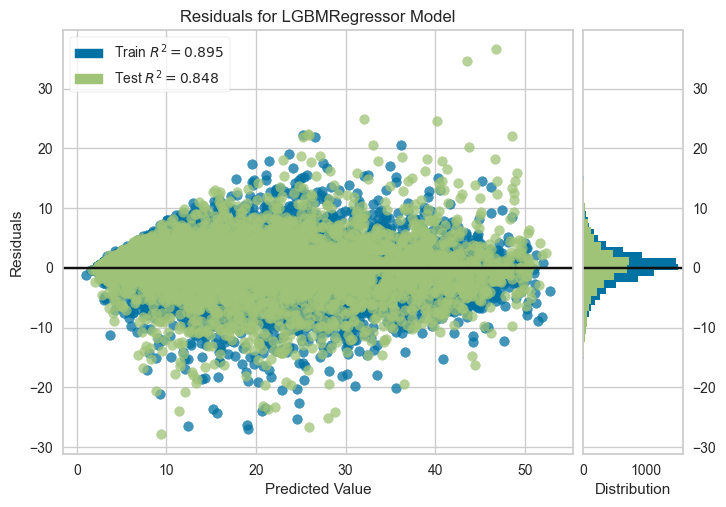

In [25]:
exp.plot_model(best_model)

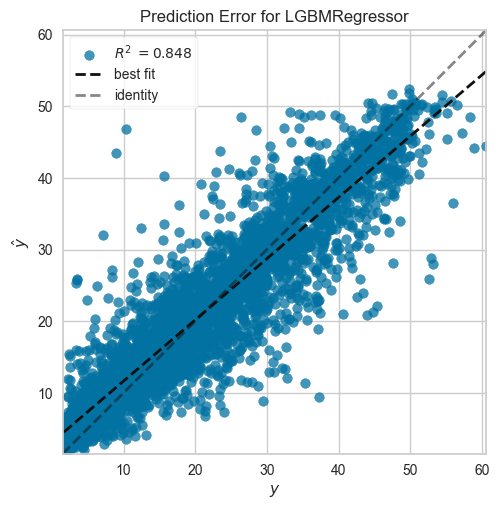

In [26]:
exp.plot_model(best_model, plot='error')

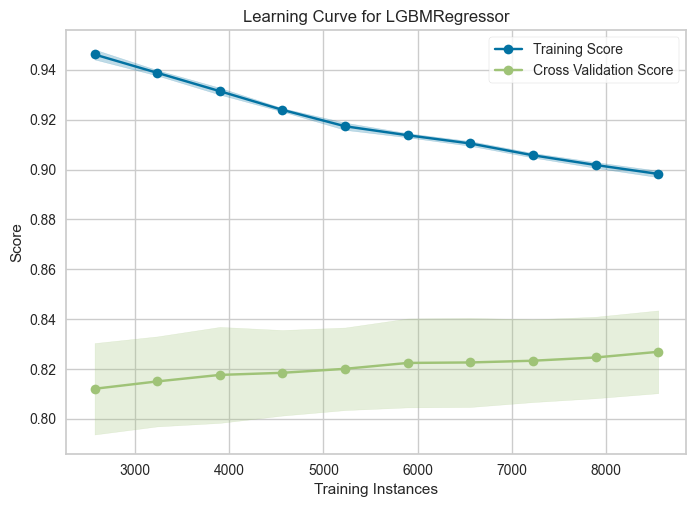

In [27]:
exp.plot_model(best_model, plot='learning')

In [29]:
exp.save_model(best_model, 'models/Fisrt_models')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['humidity', 'temperature',
                                              'dayofweek', 'month', 'day',
                                              'pm_2_5_lag_1', 'pm_2_5_lag_2',
                                              'pm_2_5_lag_3', 'pm_2_5_lag_4',
                                              'pm_2_5_lag_5', 'pm_2_5_lag_6',
                                              'pm_2_5_lag_7'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('remove_outliers',
                  TransformerWrapper(transformer=RemoveOutliers(random_state=123))),
                 ('trained_model',
                  LGBMRegressor(device='gpu', n_jobs=-1, random_state

In [14]:
from pycaret.regression import *
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Predict on the test set
test_predictions = exp.predict_model(best_model, data=compare_data)

# Extract actual values and predicted values
y_true = compare_data["pm_2_5"].values
y_pred = test_predictions["prediction_label"].values

# Calculate Regression Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate MAPE and Accuracy
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error
accuracy = 100 - mape  # Convert to Accuracy %

# Print Results
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.8827,28.4557,5.3344,0.3819,0.1738,0.1156


R² Score: 0.3819
Mean Absolute Error (MAE): 2.8827
Root Mean Squared Error (RMSE): 5.3344
Mean Absolute Percentage Error (MAPE): 11.56%
Accuracy: 88.44%


In [35]:
from pycaret.regression import *
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Predict on the test set
test_predictions = exp.predict_model(best_model, data=df)

# Extract actual values and predicted values
y_true = df["pm_2_5"].values
y_pred = test_predictions["prediction_label"].values

# Calculate Regression Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate MAPE and Accuracy
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error
accuracy = 100 - mape  # Convert to Accuracy %

# Print Results
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.8905,17.9784,4.2401,0.8841,0.2473,0.2084


R² Score: 0.8841
Mean Absolute Error (MAE): 2.8905
Root Mean Squared Error (RMSE): 4.2401
Mean Absolute Percentage Error (MAPE): 20.84%
Accuracy: 79.16%


In [30]:
from pycaret.regression import *
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Predict on the test set
test_predictions = exp.predict_model(best_model, data=df_test)

# Extract actual values and predicted values
y_true = df_test["pm_2_5"].values
y_pred = test_predictions["prediction_label"].values

# Calculate Regression Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate MAPE and Accuracy
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error
accuracy = 100 - mape  # Convert to Accuracy %

# Print Results
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,3.3688,24.1748,4.9168,0.8508,0.2988,0.2842


R² Score: 0.8508
Mean Absolute Error (MAE): 3.3688
Root Mean Squared Error (RMSE): 4.9168
Mean Absolute Percentage Error (MAPE): 28.42%
Accuracy: 71.58%


In [32]:
df_test2 = pd.read_csv("data_preprocess\export-jsps017-1h.csv", parse_dates=["timestamp"], index_col="timestamp")
df_test2 = df_test2.sort_values(by="timestamp")
df_test2['dayofweek'] = df_test2.index.dayofweek
df_test2['month'] = df_test2.index.month
df_test2['day'] = df_test2.index.day

In [33]:
# Create lag features for the past 7 days
for lag in range(1, 8):  # Lags from 1 to 7 days
    df_test2[f'pm_2_5_lag_{lag}'] = df_test2['pm_2_5'].shift(lag)

# Drop NaN values caused by shifting
df_test2.dropna(inplace=True)
df_test2 = df_test2.drop(columns=["Unnamed: 0", "timezone", "pm_2_5_sp"], axis=1)

In [34]:
from pycaret.regression import *
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Predict on the test set
test_predictions = exp.predict_model(best_model, data=df_test2)

# Extract actual values and predicted values
y_true = df_test2["pm_2_5"].values
y_pred = test_predictions["prediction_label"].values

# Calculate Regression Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate MAPE and Accuracy
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error
accuracy = 100 - mape  # Convert to Accuracy %

# Print Results
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,11.4477,1554.7780,39.4307,0.2584,0.4466,0.3249


R² Score: 0.2584
Mean Absolute Error (MAE): 11.4477
Root Mean Squared Error (RMSE): 39.4307
Mean Absolute Percentage Error (MAPE): 32.49%
Accuracy: 67.51%
